In [1]:
import numpy as np
from matplotlib import pyplot as plt

# Assignment 9

## Andrew Loeppky
## Cloud Microphysics Fall 2020

In this assignment we will simulate the growth of cloud droplets in a cloud according to the continuous growth model.  For the following exercises assume Stokes flow, with the drop falling at its terminal velocity ($U_\infty$), a cloud water content (LWC) of $1 gm^{−3}$, and a constant ambient temperature of $5°C$.  State which equations and which additional assumptions you use.

**1.  (7 points)** Code a simple model that calculates altitude and droplet radius over time for various updraft velocities for a droplet with an initial radius of $10μm$.  For now, assume the collision efficiency to be unity.  Verify your code by comparing your results with Figure 11.2 (use the same updraft speeds as Fig. 11.2).Present your plot.  No integration is needed for this problem. Briefly discuss how your results demonstrate the evolution of cloud droplets within the cloud.  How does your plot compare to Figure 11.2, and what could be a reason for the difference(s) you observe?

Stokes flow equation from chapter 8: 

$$
F_D = 6\pi\eta a U_\infty \tag{Wang 8.26}
$$

We will further assume that the droplet is growing slowly enough such that it never substantially deviates from terminal velocity:

$$
F_D = mg \rightarrow \frac{4}{3}\pi a^3 \rho_w g = 6\pi\eta a U_\infty
$$

$$
U_\infty = \frac{2 a^2 \rho_w g}{9\eta} \tag{1}
$$

We assume $U_\infty$ is purely vertical (up is defined to be the positive direction). In the presence of a constant updraft $W$:

$$
\frac{dz}{dt} = W - U_\infty = W - \frac{2 a^2 \rho_w g}{9\eta}
$$

Convert to a finite difference to integrate numerically:

$$
\frac{\Delta z}{\Delta t} = W - \frac{2 a^2 \rho_w g}{9\eta}
$$

$$
z_{i+1} = z_i + \left(W - \frac{2 a_i^2 \rho_w g}{9\eta}\right)\Delta t \tag{2}
$$

We can similarly find an equation for $a(t)$ starting with Wang 11.3:

$$
\frac{da}{dt} = \frac{E_cU_\infty w_L}{4\rho_w} \tag{Wang 11.3}
$$

Sub in (1) for $U_\infty$ and use the same forward difference formula:

$$
\frac{da}{dt} = \frac{E_c\frac{2 a^2 \rho_w g}{9\eta}w_L}{4\rho_w} = \frac{E_ca^2gw_L}{18\eta}
$$

$$
a_{i+1} = a_i + \frac{E_ca_i^2gw_L}{18\eta}\Delta t \tag{3}
$$


Implement this in code assuming $E_c = 1$, and choosing $a_0=10\mu m$, $z_0 = 0m$ and $\Delta t = 1s$: 

In [2]:
# Define prelim variables
E_c = 1.0
a0 = 10e-6  # m
rho_w = 1000.0  # kg/m3
z0 = 0.0  # m, height above cloud base
g = 9.81  # m/s2
eta = 1.754e-5  # https://www.engineersedge.com/physics/viscosity_of_air_dynamic_and_kinematic_14483.htm
w_L = 0.001  # kg/m3
dt = 1  # s
W = 1  # m/s

In [3]:
def z_next(z_prev, a_prev):
    """
    implement equation 2
    """
    z = z_prev + (W - 2 * a_prev ** 2 * rho_w * g / (9 * eta)) * dt
    return z


def a_next(a_prev):
    """
    implement equation 3
    """
    a = a_prev + E_c * a_prev ** 2 * g * w_L / (18 * eta) * dt
    return a



def timeloop():
    """
    loop through time, calculate radius and position of droplet,
    stop when it falls back to cloudbase
    """
    # Make arrays to hold the time series a_i and z_i
    a = np.array([a0])
    z = np.array([z0])
    i = 1
    # do the loop
    while True:
        z = np.append(z, z_next(z[i - 1], a[i - 1]))
        a = np.append(a, a_next(a[i - 1]))
        if z[i - 1] < 0.0:
            break
        i += 1
    # plot results
    return a, z

Text(0.5, 1.0, 'Continuous Growth Model, Varying Updraft Speed')

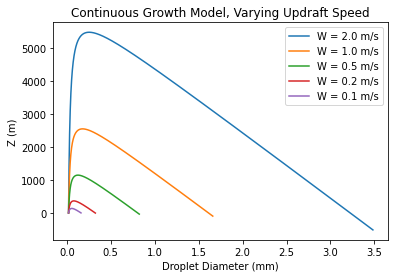

In [4]:
updrafts = np.array([2., 1., 0.5, 0.2, 0.1])  # m/s up
for updraft in updrafts:
    W = updraft
    a, z = timeloop()
    plt.plot(a * 2e3, z, label=f"W = {updraft} m/s")
plt.legend()
plt.xlabel("Droplet Diameter (mm)")
plt.ylabel("Z (m)")
plt.title("Continuous Growth Model, Varying Updraft Speed")

Discussion:

 * Net velocity is the difference between updraft speed (up) and terminal fall velocity (down). Small droplets have small terminal velocities, so initially they rise relative to cloud base.
 * Some time later, a droplet grows until its fall speed is equal to the updraft velocity, seen as the peak of each curve. Larger updrafts allow droplets to grow for longer periods of time.
 * As it falls, the droplet continues to grow, gaining additional velocity until it reaches cloud base and falls as precipitation
 
Why is this plot different than fig 11.2?
 * We assumed stokes flow throughout the simulation, which underestimates fall speed for large droplets. A more sophisticated model might apply O'seen flow or another more appropriate regime after droplets reach a certain size.   

**2.  (3 points)** Now, discuss briefly how your results change with:

a) liquid water content (smaller and larger than 1 g m−3)

b) and initial size (smaller and larger than 10μm, the assumption you made in Question 1 remains for simplicity).

Let's hold the updraft speed constant at 1m/s and vary $w_L$

Text(0.5, 1.0, 'Continuous Growth Model, Varying LWC')

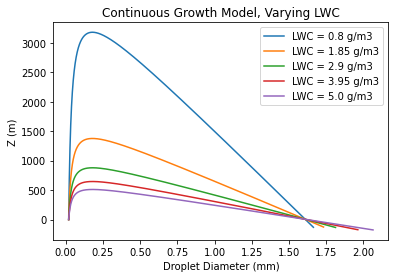

In [5]:
W = 1 # m/s
LWC = np.linspace(0.0008,0.005,5) # kg/m3
for lwc in LWC:
    w_L = lwc
    a, z = timeloop()
    plt.plot(a * 2e3, z, label=f"LWC = {round(lwc*1000,2)} g/m3")
plt.legend()
plt.xlabel("Droplet Diameter (mm)")
plt.ylabel("Z (m)")
plt.title("Continuous Growth Model, Varying LWC")

Unsurprisingly, more LWC leads to larger droplets precipitating out of the cloud. Since they grow much faster, they do not reach the same height as those with comparatively lower LWC. However, the continuous growth model assumes collectee drops are virtually stationary compared to the collector, which becomes less and less realistic as LWC increases and collectee droplets grow larger.

Do it again, holding LWC steady and varying initial droplet size

Text(0.5, 1.0, 'Continuous Growth Model, Varying Initial Droplet Size')

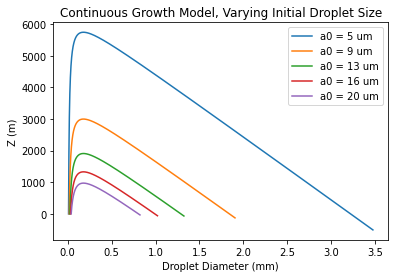

In [6]:
w_L = 0.001 # kg/m3
dropsize = np.linspace(5e-6,20e-6,5) # m
for size in dropsize:
    a0 = size
    a, z = timeloop()
    plt.plot(a * 2e3, z, label=f"a0 = {round(a0*1e6)} um")
plt.legend()
plt.xlabel("Droplet Diameter (mm)")
plt.ylabel("Z (m)")
plt.title("Continuous Growth Model, Varying Initial Droplet Size")

Droplet growth is quite sensitive to initial size. Larger droplets with high initial terminal velocities do not make it to higher altitudes, and thus spend much less time in the cloud and so grow to a smaller final dimension as compared with droplets that start small.

**3.  (2  points)**  Now  assume  a  more  realistic  case  with  Ec<1.   How  does  a  more  realistic collision efficiency affect your results?  Explain.

Make one more loop, varying $E_c$:

Text(0.5, 1.0, 'Continuous Growth Model, Varying Collection Efficiency')

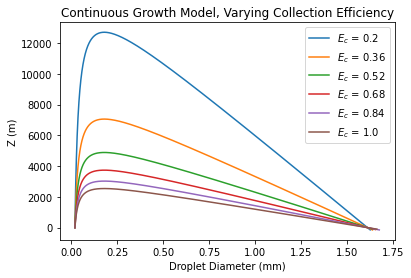

In [7]:
a0 = 10e-6  # m
coll_eff = np.linspace(0.2,1,6)
for eff in coll_eff:
    E_c = eff
    a, z = timeloop()
    plt.plot(a * 2e3, z, label=f"$E_c$ = {round(eff,2)}")
plt.legend()
plt.xlabel("Droplet Diameter (mm)")
plt.ylabel("Z (m)")
plt.title("Continuous Growth Model, Varying Collection Efficiency")

As collection efficiency decreases, droplets grow more slowly and therefore reach much higher altitudes as compared to more efficient drops. Note that more efficient droplets reach a slightly larger final size.